### Imports

In [1]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import cloudpickle
import matplotlib.pyplot as plt

### Create Env

In [2]:
with open('dataset/train.pkl', 'rb') as f:
    train_data = cloudpickle.load(f)
with open('dataset/test.pkl', 'rb') as f:
    test_data = cloudpickle.load(f)
train_data = train_data.loc[:, ['close'] + list(range(10))]
test_data = test_data.loc[:, ['close'] + list(range(10))]
train_data.columns = ['Close'] + list(range(10))
test_data.columns = ['Close'] + list(range(10))


### Train Env

Using cuda device
info: {'total_reward': 32853861.591160834, 'total_profit': 1.1871316703355819, 'position': 1}
info: {'total_reward': 2581097.5751334336, 'total_profit': 1.0463801301677578, 'position': 1}
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 1873 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1364          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.2312958e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003    

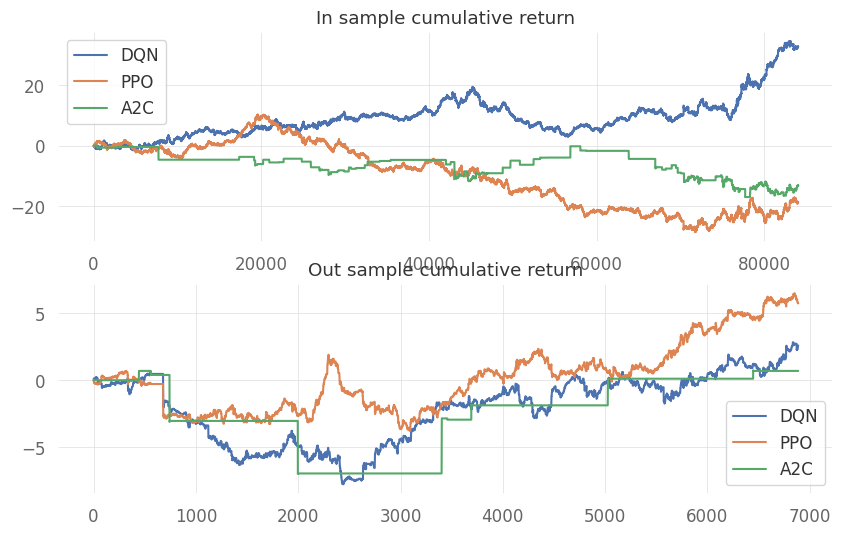

In [3]:
mnl = ['DQN', 'PPO', 'A2C']
insample_result_df = pd.DataFrame(index=train_data.index)
outsample_result_df = pd.DataFrame(index=test_data.index)
insample_action_df = pd.DataFrame(index=train_data.index)
outsample_action_df = pd.DataFrame(index=test_data.index)
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)
for model_name in mnl:
    window_size = 10
    start_index = window_size
    end_index = len(train_data)

    env_maker = lambda: gym.make(
        'forex-v0',
        df = train_data,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env = DummyVecEnv([env_maker])
    if model_name == 'DQN':
        model = DQN('MlpPolicy', env, verbose=1)
    elif model_name == 'PPO':
        model = PPO('MlpPolicy', env, verbose=1)
    elif model_name == 'A2C':
        model = A2C('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=100000)
    env_maker = lambda: gym.make(
        'forex-v0',
        df = train_data,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )
    env = env_maker()
    observation = env.reset()
    ret_list = []
    action_list = []
    while True:
        observation = observation[np.newaxis, ...]

        # action = env.action_space.sample()
        action, _states = model.predict(observation)
        observation, reward, done, info = env.step(action)
        ret_list.append(reward)
        action_list.append(action)
        # env.render()
        if done:
            print("info:", info)
            break
    pnl = pd.Series(ret_list).cumsum().add(1000000).pct_change().fillna(0).add(1).cumprod().sub(1)
    insample_result_df[f'{model_name}'] = pnl
    insample_action_df[model_name] = pd.Series(action_list)
    ax1.plot(pnl, label=model_name)
    
    start_index = window_size
    end_index = len(test_data)
    env_maker = lambda: gym.make(
        'forex-v0',
        df = test_data,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )
    env = env_maker()
    observation = env.reset()
    ret_list = []
    action_list = []
    while True:
        observation = observation[np.newaxis, ...]

        # action = env.action_space.sample()
        action, _states = model.predict(observation)
        observation, reward, done, info = env.step(action)
        ret_list.append(reward)
        # env.render()
        action_list.append(action)
        if done:
            print("info:", info)
            break
    pnl = pd.Series(ret_list).cumsum().add(1000000).pct_change().fillna(0).add(1).cumprod().sub(1)
    outsample_result_df[f'{model_name}'] = pnl
    outsample_action_df[model_name] = pd.Series(action_list)
    ax2.plot(pnl, label=model_name)
ax1.legend()
ax2.legend()
ax1.set_title('In sample cumulative return')
ax2.set_title('Out sample cumulative return')
plt.savefig(f'{model_name}.png')
    

In [4]:
pd.concat([insample_result_df, insample_action_df], axis=1).to_excel('insample.xlsx')
pd.concat([outsample_result_df, outsample_action_df], axis=1).to_excel('outsample.xlsx')